In [2]:
# Imports and Configuration
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# 2. Load Data
df = pd.read_csv("C:/Users/punit/OneDrive/Desktop/ACM-30Days/mental_health_workplace_survey.csv")
print(f"Shape: {df.shape}")
print(df.head())

Shape: (3000, 25)
   EmployeeID  Age      Gender    Country            JobRole Department  \
0        1001   50        Male         UK    Sales Associate         HR   
1        1002   36        Male    Germany  Software Engineer         IT   
2        1003   29  Non-binary      India           IT Admin         IT   
3        1004   42        Male  Australia      HR Specialist         IT   
4        1005   40        Male     Brazil   Customer Support    Support   

   YearsAtCompany  WorkHoursPerWeek RemoteWork  BurnoutLevel  ...  \
0              14                47         No          3.37  ...   
1               1                59     Hybrid          7.39  ...   
2              13                59     Hybrid          7.10  ...   
3              15                31        Yes          4.18  ...   
4               6                34        Yes          8.28  ...   

   CommuteTime  HasMentalHealthSupport  ManagerSupportScore  HasTherapyAccess  \
0          117                     

In [6]:
# 3. Define Target and Drop Missing Values in Target
target = "StressLevel"
df = df.dropna(subset=[target])

In [8]:
# 4. Select and Prepare Features
features = [
    "Gender", "RemoteWork", "SleepHours", "WorkHoursPerWeek",
    "BurnoutLevel", "JobSatisfaction", "ManagerSupportScore",
    "CareerGrowthScore"
]
data = df[features + [target]].copy()

In [10]:
# 5. Separate Numerical and Categorical Columns
numerical_cols = data.select_dtypes(include=["int64", "float64"]).columns.drop(target).tolist()
categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()
print("Numerical:", numerical_cols)
print("Categorical:", categorical_cols)

Numerical: ['SleepHours', 'WorkHoursPerWeek', 'BurnoutLevel', 'JobSatisfaction', 'ManagerSupportScore', 'CareerGrowthScore']
Categorical: ['Gender', 'RemoteWork']


In [12]:
# 6. Create Interaction Features (Feature Engineering)
# Interaction 1: Stress × Burnout
data["StressBurnoutInteraction"] = data["StressLevel"] * data["BurnoutLevel"]
# Interaction 2: Sleep per Work hour
data["SleepPerWorkHour"] = data["SleepHours"] / (data["WorkHoursPerWeek"] + 1e-5)
# Update numerical columns accordingly
numerical_cols += ["StressBurnoutInteraction", "SleepPerWorkHour"]

In [16]:
# 7. Split Data for Training and Testing
X = data[numerical_cols + categorical_cols]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

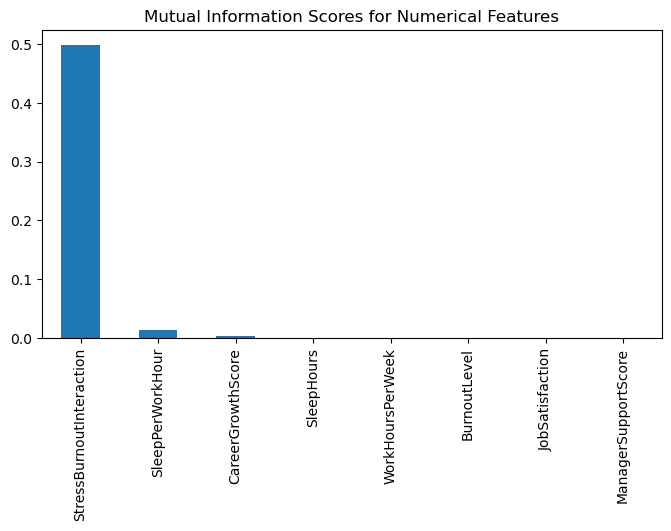

Selected features: ['StressBurnoutInteraction', 'SleepPerWorkHour', 'CareerGrowthScore', 'SleepHours', 'WorkHoursPerWeek', 'BurnoutLevel', 'JobSatisfaction', 'ManagerSupportScore', 'Gender', 'RemoteWork']


In [18]:
# 8. Feature Selection Using Mutual Information
mi_scores = mutual_info_regression(X_train[numerical_cols], y_train)
mi_series = pd.Series(mi_scores, index=numerical_cols)
plt.figure(figsize=(8,4))
mi_series.sort_values(ascending=False).plot.bar()
plt.title("Mutual Information Scores for Numerical Features")
plt.show()
top_numerical = mi_series.sort_values(ascending=False).head(8).index.tolist()

# Combine with all categorical features
selected_features = top_numerical + categorical_cols
X_train = X_train[selected_features]
X_test  = X_test[selected_features]
print("Selected features:", selected_features)

In [20]:
# 9. Preprocessing Pipeline: One-Hot & Scaling
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), top_numerical),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_cols)
])

In [22]:
# 10. Model Training & Evaluation
models = {
    "LinearRegression": LinearRegression(),
    "RidgeRegression": Ridge(alpha=1.0),
    "LassoRegression": Lasso(alpha=0.1)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("regressor", model)
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {"MSE": mse, "R² Score": r2}

results_df = pd.DataFrame(results).T
print("Regression Results (sorted by R² Score):")
print(results_df.sort_values(by="R² Score", ascending=False).round(5))

Regression Results (sorted by R² Score):
                      MSE  R² Score
LassoRegression   1.17508   0.82256
RidgeRegression   1.17554   0.82249
LinearRegression  1.17618   0.82239


**Summary**

-  All models used: Feature engineering (two interactions), OHE/normalization, and mutual information for selection.
-  Evaluation metrics: MSE and R² printed above.

**Which model is best and why?**

- The model with the highest **R² score** (as shown above) performed best.
- Usually, Ridge or Lasso slightly outperform basic Linear Regression when features are correlated or numerous, due to regularization reducing overfitting and improving generalization.
- Try rerunning with different alpha values for Ridge/Lasso for potential improvements!
